In [1]:
from sklearn.experimental import enable_iterative_imputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import IterativeImputer, KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
d_tr = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/Titanic/train.csv', index_col='PassengerId')
d_te = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/Titanic/test.csv', index_col=0)

### Cleaning and preparing data

In [4]:
data = clean_data(d_tr)
data.sample(7)

,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Survived,Pclass,Age,Fare,Embarked,IsAlone
604,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,1,4.0,2,1.0,1
149,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,2,4.0,1,0.0,1
567,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,3,3.0,2,0.0,0
587,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,1,5.0,3,1.0,0
241,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,3,NaN,2,2.0,0
369,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,3.0,3,1.0,1
799,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,3,3.0,2,0.0,0


In [9]:
data.isna().sum()

Sex_female        0
Sex_male          0
Title_Master      0
Title_Miss        0
Title_Mr          0
Title_Mrs         0
Title_Other       0
Survived          0
Pclass            0
Age             177
Fare              0
Embarked          2
IsAlone           0
dtype: int64

### Divining into X, and y

In [5]:
X = data.drop(columns='Survived').copy()
y = data.Survived.copy().astype('int') #To avoid getting an error that 'y' is unknown

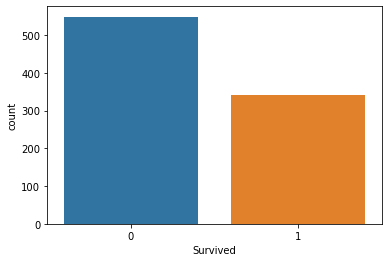

In [8]:
sns.countplot(x=y);

### see the percentage of each class

In [54]:
total_0 = y[y==0].value_counts()
total_1 = y[y==1].value_counts()

print('Not survived = {}, ({} %) '.format(total_0[0], total_0[0]/len(y)))
print('\nSurvived     = {}, ({} %) '.format(total_1[1], total_1[1]/len(y)))

Not survived = 549, (0.6161616161616161 %) 

Survived     = 342, (0.3838383838383838 %) 


In [52]:
#type(total_1[0])
total_0.shape
#total_1[1]

(1,)

### Calculating missing values

In [39]:
X.isna().sum()

Sex_female        0
Sex_male          0
Title_Master      0
Title_Miss        0
Title_Mr          0
Title_Mrs         0
Title_Other       0
Pclass            0
Age             177
Fare              0
Embarked          2
IsAlone           0
dtype: int64

## training and test set

In [6]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, test_size=0.16)

### IterativeImputer

In [110]:
imputer = IterativeImputer(max_iter=20)
#iterative = IterativeImputer()

### KNNImputer

In [58]:
imputer = KNNImputer()

# LogisticRegression

In [70]:
model = LogisticRegression(max_iter=10000)

param_grid = [{ 
              'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'model__penalty': ['l2'],
              'model__C': [0.01, 0.1, 1, 10, 100],
              'model__class_weight' : ['balanced', None],
              #'impute__imputation_order': ['ascending', 'descending', 'roman', 'arabic', 'random'],
              #'impute__max_iter': [1,2,3,5,7,11,13,17,19],
    
              'impute__n_neighbors': [1,2,3,5,7,11,13,17,19]
              }]

### Results

In [82]:
gs.best_params_

{'model__solver': 'liblinear',
 'model__penalty': 'l2',
 'model__class_weight': None,
 'model__C': 100,
 'impute__n_neighbors': 1}

In [81]:
gs.best_score_

0.8163004577611319

# RandomForestClassifier

In [117]:
model = RandomForestClassifier()

param_grid = [{
                'model__n_estimators': [10, 100, 1000],
                'model__max_features': ['sqrt', 'log2'],
                #'impute__imputation_order': ['ascending', 'descending', 'roman', 'arabic', 'random']
    
                'impute__n_neighbors': [1,2,3,5,7,11,13,17,19]
               }]

## GradientBoostingClassifier

In [ ]:
model = GradientBoostingClassifier()

param_grid = [{
            'n_estimators': [10, 100, 1000],
            'learning_rate': [0.001, 0.01, 0.1],
            'subsample': [0.5, 0.7, 1.0],
            'max_depth': [3, 7, 9],
    
            #'impute__imputation_order': ['ascending', 'descending', 'roman', 'arabic', 'random']
            'impute__n_neighbors': [1,2,3,5,7,11,13,17,19]
              }]

### PipeLine to impute and modelling

In [59]:
classifier = Pipeline([('impute', imputer), 
                       ('model', model)])

# Tuning Hyperparametres

In [64]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

In [78]:
gs = RandomizedSearchCV(classifier, param_distributions=param_grid, cv=cv, n_jobs=-1, n_iter=25)

In [79]:
gs.fit(X,y)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
                   estimator=Pipeline(steps=[('impute', KNNImputer()),
                                             ('model',
                                              LogisticRegression(max_iter=10000))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions=[{'impute__n_neighbors': [1, 2, 3, 5, 7,
                                                                 11, 13, 17,
                                                                 19],
                                         'model__C': [0.01, 0.1, 1, 10, 100],
                                         'model__class_weight': ['balanced',
                                                                 None],
                                         'model__penalty': ['l2'],
                                         'model__solver': ['newton-cg', 'lbfgs',
                                                      

In [80]:
gs.best_score_

0.8163004577611319

In [134]:
gs.best_params_

{'model__solver': 'liblinear', 'model__C': 10, 'impute__n_neighbors': 2}

0    0.616162
Name: Survived, dtype: float64

In [ ]:
creo que es por que Y es flot hay que convertirla a 'int'

## Tools

In [3]:
def Fare(s):
    #s['FareBand'] = pd.qcut(s['Fare'], 4)
    s.loc[ s['Fare'] <= 7.91, 'Fare'] = 0
    s.loc[(s['Fare'] > 7.91) & (s['Fare'] <= 14.454), 'Fare'] = 1
    s.loc[(s['Fare'] > 14.454) & (s['Fare'] <= 31), 'Fare']   = 2
    s.loc[ s['Fare'] > 31, 'Fare'] = 3

    #Cambiar tipo de columna
    s['Fare'] = s['Fare'].astype(int)
    
    return s

def Age(s): #if it uses 2 times it will set all values to 1.0
            #recive a copy
            #does not touch nan values
    s.loc[(s.Age <= 13), 'Age'] = 1
    s.loc[(s.Age > 13) & (s.Age <= 18), 'Age'] = 2
    s.loc[(s.Age > 18) & (s.Age <= 30), 'Age'] = 3
    s.loc[(s.Age > 30) & (s.Age <= 50), 'Age'] = 4
    s.loc[(s.Age > 50), 'Age'] = 5
    
    return s

def FamilySize(s):
    s['FamilySize'] = s['SibSp'] +  s['Parch'] + 1
    
    s['FamilySize'] = s['FamilySize'].astype(int)
    #s['Survived'] = s['Survived'].astype(int)
    
    s['IsAlone'] = 0
    s.loc[s['FamilySize'] == 1, 'IsAlone'] = 1
    
    return s.drop(columns=['SibSp', 'Parch', 'FamilySize']).copy()

def Titles(s):
    #str.extract(' ([A-Za-z]+)\.')
    s['Title'] = s['Name'].str.extract(' ([A-Za-z]+)\.')
    s['Title'] = s['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr',                                       
                                    'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
    s['Title'] = s['Title'].replace(['Mlle', 'Ms'], 'Miss')
    s['Title'] = s['Title'].replace(['Mme'], 'Mrs')
    
    return s.drop(columns='Name').copy()

def SexEmbarkedTitle_to_OneHot(s):
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    #s.columns
    
    # ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
    
    cat_features = ['Sex', 'Title']
    res_features = ['Survived', 'Pclass', 'Age', 'Fare', 'Embarked', 'IsAlone']
    
    transformer = ColumnTransformer([('cat', encoder, cat_features)], remainder='passthrough')
    
    transformer.fit(s)
    
    tranformed_names = transformer.named_transformers_['cat'].get_feature_names_out(cat_features)
    #tranformed_names
    
    new_names = np.append(tranformed_names, res_features)
    
    return pd.DataFrame(transformer.transform(s), columns=new_names)


# Para prepara el df para age y embarked prediction

def Age_Embarked(df):

    age_X_te = df.loc[df.Age.isna()].copy()
    embarked_X_te = df.loc[df.Embarked.isna()].copy()

    embarked_X_te.drop(columns=['Embarked'], inplace=True)
    age_X_te.drop(columns=['Age'], inplace=True)


    age_X_tr = df.dropna(subset=['Age', 'Embarked']).copy()
    age_y_tr = age_X_tr.Age


    embarked_X_tr = df.dropna(subset=['Age', 'Embarked']).copy()
    embarked_y_tr = embarked_X_tr.Embarked

    # to leave the df with all columns
    # age_X_tr.drop(columns=['Age'], inplace=True)
    # embarked_X_tr.drop(columns=['Embarked'], inplace=True)
    
    return (age_X_te, embarked_X_te, age_X_tr, age_y_tr, embarked_X_tr, embarked_y_tr)

def get_x_y(df, y):
    #resives an copy of a df and return X_tr, y_tr
    X_tr = df.drop(columns=[y])
    y_tr = df[y]
    
    return X_tr, y_tr



#temp01 = temp01.drop(columns=['Ticket', 'Cabin'])

def clean_data(df=None):
    '''This function uses Title(), Fare(), Age(), FamilySize()
       functions to clean up the Data Fram that it recives.
    '''
    
    d_clean = Titles(df)
    d_clean = Fare(d_clean)
    d_clean = Age(d_clean)
    d_clean = FamilySize(d_clean)

    #OneHot aplied
    d_clean.drop(columns=['Ticket', 'Cabin'], inplace=True)

    d_clean = SexEmbarkedTitle_to_OneHot(d_clean)
    
    d_clean['Embarked'] = d_clean['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2})#.astype(int)
        
    return d_clean


#Converting clean_data(df) function into one that 
#can be used in a pipeline
#cleanDataFrame = FunctionTransformer(clean_data)
